In [20]:
import numpy as np
import h5py
import lmdb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
from PIL import Image
from bs4 import BeautifulSoup
import requests
import re
import os
import glob
import pathlib
import time
import datetime
import json
import pprint
from ip_basic import depth_map_utils
# for nyu, tum, diode
def center_crop(im, new_width=None, new_height=None):
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return im.crop((left, top, right, bottom))
def show_example(path='/hy-tmp/stage1/rgb_depth_large.mat', idx=0):
    with  h5py.File(path,'r') as t:
        rgb = t['rgb']
        depth = t['depth']
        print(rgb.shape)
        rgbi = rgb[idx]
        depthi = depth[idx]
    fig=plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    xx = np.arange(0,256)
    yy = np.arange(0,256)
    X, Y = np.meshgrid(xx, yy)
    ax1.plot_surface(X,Y,depthi.squeeze(),cmap='rainbow')
    plt.show()
    plt.close()

    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(rgbi)
    ax2.imshow(depthi)
    plt.show()
    plt.close()
# for tum
def depth_completion(depthi, loop=2):
    '''ip_basic depth completion
    '''
    fill_type = 'fast'
    extrapolate = True
    blur_type = 'bilateral'
    for _ in range(loop):
        if fill_type == 'fast':
            depthi = depth_map_utils.fill_in_fast(
                depthi, extrapolate=extrapolate, blur_type=blur_type)
        elif fill_type == 'multiscale':
            depthi, process_dict = depth_map_utils.fill_in_multiscale(
                depthi, extrapolate=extrapolate, blur_type=blur_type,
                show_process=False)
    return depthi
def get_timestamp(v):
    f = v.split("/")[-1]
    stamp = f.replace(".png","")
    return float(stamp)
def align_rgb_depth(rgbs, depths, bi=True):
    '''Align two sequeces by timestamps in the filenames
    Use rgb as base
    '''
    if len(rgbs)==len(depths):
        return rgbs, depths
    res_rgbs = rgbs
    res_depths = []
    for i, v in enumerate(res_rgbs):
        target_stamp = get_timestamp(v)
        current_d = depths[0]
        if bi:
            # bi-search
            left = 0
            right = len(depths)-1
            while left<=right:
                mid = (left+right)//2
                now_stamp = get_timestamp(depths[mid])
                if now_stamp==target_stamp:
                    left=mid
                    right=mid-1
                elif now_stamp>target_stamp:
                    right = mid-1
                else:
                    left = mid+1
            if left==0:
                current_d = depths[left]
            elif right==len(depths)-1:
                current_d = depths[right]
            else:
                current_d = depths[left] if abs(get_timestamp(depths[left])-target_stamp)<abs(get_timestamp(depths[left-1])-target_stamp) else depths[left-1]
        else:
            current_min = 100000000
            for j, p in enumerate(depths):
                current_stamp = get_timestamp(p)
                if abs(target_stamp-current_stamp)<current_min:
                    current_min =  abs(target_stamp-current_stamp)
                    current_d = p
        res_depths.append(current_d)
    assert len(res_rgbs)==len(res_depths)
    return res_rgbs, res_depths

## Split episode and panorama

In [24]:
# Adapted from https://github.com/fuenwang/Equirec2Perspec

import os
import sys
import cv2
import numpy as np
import math

class Equirectangular:
    def __init__(self, img):
        self._img = img
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    

    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS = 128):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0     
        
        hFOV = math.radians(FOV)
        wFOV = 2*math.atan(float(width)/height * np.tan(hFOV / 2.0))

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (math.pi - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(wFOV / 2.0) / np.sin(wangle)
        w_interval = w_len / (width - 1)

        hangle = (math.pi - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(hFOV / 2.0) / np.sin(hangle)
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], np.float32) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)
        
        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        #for x in range(width):
        #    for y in range(height):
        #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
        #return self._img 
    
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

"""从全景图得到子图的代码"""
# Simulator image parameters
VIEWPOINT_SIZE = 36
FEATURE_SIZE = 2048

WIDTH = 640
HEIGHT = 480
VFOV = 60
HFOV = 75  # makes a VFOV of 60

SCANS = ['TJARKatROOM', 'TJARKmeet302', 'TJARKmeet305', 'TJARKmeeting603']

def equirectangular_to_perspective(image, save_path, viewpoint):
    ''' Convert an equirectangular pano to 36 perspective images used by the VLN
        agent. Construct it with 12 heading 
        viewpoints and 3 elevation viewpoints, starting with the heading that is
        directly in front. The agent works better if these views are aligned to the
        building. '''
    equi = Equirectangular(image)  # RGB shape of [H, W, 3]
    im_width = 640
    im_height = 480
    vfov = 60

    # heading, elevation. Here, heading is defined from the x-axis, and turning right 
    # is positive. This matches the matterport sim, but opposite to ros
    he = np.zeros((3, 12, 2), dtype=np.float32)

    
    # for i,v_deg in enumerate(range(0, 30, 30)):
        # 注意！ 这个-150°是和全景图在MP3D模拟器中的航向角挂钩的，MP3D中的航向角=150 - ros_heading
    v_deg = 0
    i = 0
    for j,u_deg in enumerate(range(-150, 210, 60)):
        # Negate heading since for e2p turning right is positive, opposite in ros
        head = -math.radians(u_deg)
        he[i,j] = [head + 2*math.pi if head<0 else head, math.radians(v_deg)]
        p_im = equi.GetPerspective(vfov, u_deg, v_deg, im_height, im_width)
        cv2.imwrite(os.path.join(save_path, f"{viewpoint}_{str(12*i+j)}.jpg"), p_im)
           
def roll_image(image, pano_heading_rad):
    """
    input: 
        image: theta相机获得的全景图,机器人坐标系
        pano_heading_rad: 机器人朝向
    output:
        image: 将全景图转到地图坐标系0方向
    """
    x_axis = 1 # width
    roll_pixels = -int(pano_heading_rad / (math.pi * 2) * image.shape[x_axis])
    rolled_image = np.roll(image, roll_pixels, axis=x_axis)
    return rolled_image           

In [25]:
raw_data_path = "/root/autodl-tmp/r2r/"
dataset_path = "/root/autodl-tmp/r2r/tjark_r2r_all.json"
new_data_path = "/root/autodl-tmp/r2r_split/"
os.makedirs(new_data_path, exist_ok=True)
with open(dataset_path, "r") as f:
    tjark_r2r = json.loads(f.read())
for i, ep in enumerate(tjark_r2r):
    scan = ep["scan"]+"_imgs"
    path = ep["path"]
    inst = ep["instructions"][0]

    os.makedirs(os.path.join(new_data_path, str(i)), exist_ok=True)
    inst_path = os.path.join(new_data_path, str(i), "instruction.txt")
    with open(inst_path,"w") as f:
        f.write(inst)

    for j,vp in enumerate(path):
        img_path = os.path.join(raw_data_path, scan, vp+"_equirectangular.jpg")
        img = cv2.imread(img_path)
        os.makedirs(os.path.join(new_data_path, str(i), "rgb"), exist_ok=True)
        equirectangular_to_perspective(img, os.path.join(new_data_path, str(i), "rgb"), j)

In [5]:
ep

{'scan': 'TJARKjirenlou_night',
 'path': ['wbzgi90qeprorulk4vp5gk4hwp6c3lh3',
  'gwikcem025hd4p2d3fq5h4zwaof9rt0u',
  'eey023eprkn3hm4kbh7x36wp7c0tiwa8',
  'eurzc2bcumco2xoyqwg2orylbqegpyyg',
  '7v2m6buxe4lx2f80w8m5g8hd0x2b8va1'],
 'instructions': ['Turn left in the corridor, pass the trolley and the box, then turn left and wait at the door next to the box.'],
 'heading': 1.5882496417976402,
 'distance': 8.562208513309029,
 'path_id': 77}

## Depth estimation

In [33]:

# timm==0.6.7
# 
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch

from torchvision import transforms

import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

resize = transforms.Resize([384, 512])
scale = 4

test_image = 'C:/Users/tangjg/Desktop/08c774f20c984008882da2b8547850eb_skybox1_sami.jpg'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")


def load_model():
    # torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True) 
    model = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True)
    model.to(DEVICE)
    model.eval()
    return model

def InferImage(image_file):
    image = Image.open(image_file)
    origin_size = image.size
    img = ToTensor()(image).to(DEVICE).unsqueeze_(0)
    img.to(DEVICE)
    
    model = load_model()
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        out = model(img)
        out_img = Image.fromarray(out['metric_depth'].squeeze().cpu().numpy())
        out_img.resize(origin_size, Image.ANTIALIAS)
        out_img.show()

model = load_model()
def inferImageAndCompare(idx, model):
    rgb_path = f'/root/EvoEnc/r2r_split/{idx}/rgb'
    out_path = f'/root/EvoEnc/r2r_split/{idx}/depth'
    os.makedirs(out_path, exist_ok=True)

    rgb_images = os.listdir(rgb_path)
    for rgb_img in rgb_images:
        path = os.path.join(rgb_path, rgb_img)
        
        image = Image.open(path)
        origin_size = image.size
        origin_max = np.array(image).max()
        
        depth_pil = model.infer_pil(image, output_type='pil')
        
        # resize并进行scale缩放，与GT尺度相同
        depth_pil = depth_pil.resize(origin_size, Image.LANCZOS)
        out_arr = np.array(depth_pil)
        out_arr = out_arr*scale # multiplied by 4, assume it is accurate absolute depth*1000
        depth_pil = Image.fromarray(out_arr.astype(np.uint16))
        
        depth_pil.save(os.path.join(out_path, rgb_img.replace(".jpg",".png")))
for i in tqdm(range(408)):
    inferImageAndCompare(i, model)

Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


KeyboardInterrupt: 

In [14]:
out_arr.max()

1128

In [30]:
a = np.array(Image.open("/root/EvoEnc/r2r_split/0/depth/3_0.png"))

In [31]:
a.max()

6432

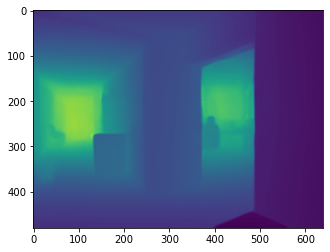

In [32]:
plt.imshow(a.astype(float))